# Think Bayes: Chapter 7

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

In [2]:
USE_SUMMARY_DATA = True

from thinkbayes2 import MakeNormalPmf
from thinkbayes2 import EvalPoissonPmf

class Hockey(Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, label=None):
        """Initializes the Hockey object.

        label: string
        """
        if USE_SUMMARY_DATA:
            # prior based on each team's average goals scored
            mu = 2.8
            sigma = 0.3
        else:
            # prior based on each pair-wise match-up
            mu = 2.8
            sigma = 0.85

        pmf = MakeNormalPmf(mu, sigma, 4)
        Suite.__init__(self, pmf, label=label)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one period
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like


In [3]:
from thinkbayes2 import MakeMixture
from thinkbayes2 import MakePoissonPmf

def MakeGoalPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

In [4]:
from thinkbayes2 import MakeExponentialPmf

def MakeGoalTimePmf(suite):
    """Makes the distribution of time til first goal.

    suite: distribution of goal-scoring rate

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

In [5]:
def ReadHockeyData(filename='hockey_data.csv'):
    """Read game scores from the data file.

    filename: string
    """
    game_list = columns.read_csv(filename, Game)

    # map from gameID to list of two games
    games = {}
    for game in game_list:
        if game.season != 2011:
            continue
        key = game.game
        games.setdefault(key, []).append(game)

    # map from (team1, team2) to (score1, score2)
    pairs = {}
    for key, pair in games.iteritems():
        t1, t2 = pair
        key = t1.team, t2.team
        entry = t1.total, t2.total
        pairs.setdefault(key, []).append(entry)

    ProcessScoresTeamwise(pairs)
    ProcessScoresPairwise(pairs)

In [6]:
def ProcessScoresPairwise(pairs):
    """Average number of goals for each team against each opponent.

    pairs: map from (team1, team2) to (score1, score2)
    """
    # map from (team1, team2) to list of goals scored
    goals_scored = {}
    for key, entries in pairs.iteritems():
        t1, t2 = key
        for entry in entries:
            g1, g2 = entry
            goals_scored.setdefault((t1, t2), []).append(g1)
            goals_scored.setdefault((t2, t1), []).append(g2)

    # make a list of average goals scored
    lams = []
    for key, goals in goals_scored.iteritems():
        if len(goals) < 3:
            continue
        lam = thinkbayes2.Mean(goals)
        lams.append(lam)

    # make the distribution of average goals scored
    cdf = thinkbayes2.MakeCdfFromList(lams)
    thinkplot.Cdf(cdf)
    thinkplot.Show()

    mu, var = thinkbayes2.MeanVar(lams)
    print('mu, sig', mu, math.sqrt(var))

    print('BOS v VAN', pairs['BOS', 'VAN'])

In [7]:
def ProcessScoresTeamwise(pairs):
    """Average number of goals for each team.

    pairs: map from (team1, team2) to (score1, score2)
    """
    # map from team to list of goals scored
    goals_scored = {}
    for key, entries in pairs.iteritems():
        t1, t2 = key
        for entry in entries:
            g1, g2 = entry
            goals_scored.setdefault(t1, []).append(g1)
            goals_scored.setdefault(t2, []).append(g2)

    # make a list of average goals scored
    lams = []
    for key, goals in goals_scored.iteritems():
        lam = thinkbayes2.Mean(goals)
        lams.append(lam)

    # make the distribution of average goals scored
    cdf = thinkbayes2.MakeCdfFromList(lams)
    thinkplot.Cdf(cdf)
    thinkplot.Show()

    mu, var = thinkbayes2.MeanVar(lams)
    print('mu, sig', mu, math.sqrt(var))


In [8]:
suite1 = Hockey('bruins')
suite2 = Hockey('canucks')

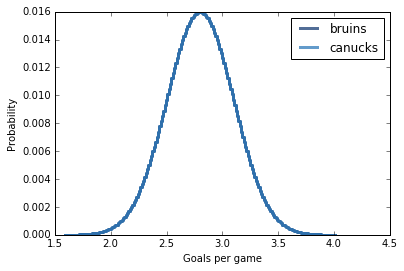

In [9]:
thinkplot.PrePlot(num=2)
thinkplot.Pmf(suite1)
thinkplot.Pmf(suite2)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

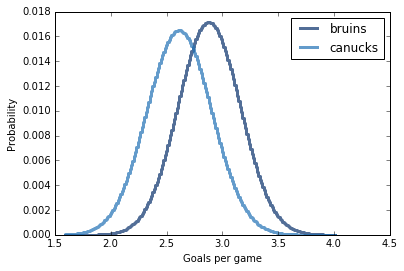

In [10]:
suite1.UpdateSet([0, 2, 8, 4])
suite2.UpdateSet([1, 3, 1, 0])

thinkplot.PrePlot(num=2)
thinkplot.Pmf(suite1)
thinkplot.Pmf(suite2)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

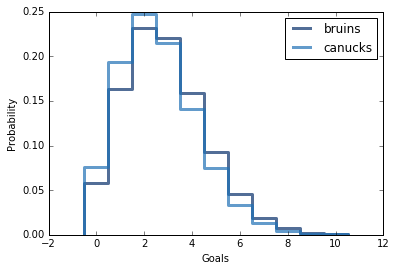

In [11]:
goal_dist1 = MakeGoalPmf(suite1)
goal_dist2 = MakeGoalPmf(suite2)

thinkplot.PrePlot(num=2)
thinkplot.Pmf(goal_dist1)
thinkplot.Pmf(goal_dist2)
thinkplot.Config(xlabel='Goals',
                ylabel='Probability')

MLE bruins 2.872
MLE canucks 2.608


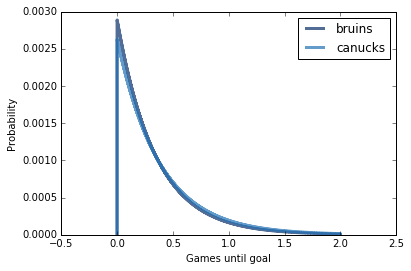

In [12]:
time_dist1 = MakeGoalTimePmf(suite1)    
time_dist2 = MakeGoalTimePmf(suite2)
 
print('MLE bruins', suite1.MaximumLikelihood())
print('MLE canucks', suite2.MaximumLikelihood())
   
thinkplot.PrePlot(num=2)
thinkplot.Pmf(time_dist1)
thinkplot.Pmf(time_dist2)    
thinkplot.Config(xlabel='Games until goal',
                   ylabel='Probability')

In [15]:
diff = goal_dist1 - goal_dist2
p_win = diff.ProbGreater(0)
p_loss = diff.ProbLess(0)
p_tie = diff.Prob(0)

print(p_win, p_loss, p_tie)


0.457996492072 0.370293408955 0.171710098973


In [17]:
p_win_in_overtime = time_dist1.ProbLess(time_dist2)
p_adjust = time_dist1.ProbEqual(time_dist2)
p_win_in_overtime += p_adjust / 2
print('p_win_in_overtime', p_win_in_overtime) 

p_win_overall = p_win + p_tie * p_win_in_overtime
print('p_win_overall', p_win_overall)

p_win_in_overtime 0.523471221795
p_win_overall 0.547881787376


**Exercise:** Which is a better way to break a tie: overtime or penalty shots?

**Exercise:** Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, trapping an insect inside. Once a trap triggers, it cannot trap another insect until it has been reset.
If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.